In [10]:
%matplotlib inline
import io

import cv2
import numpy as np
import PIL.Image

import image_transform as it

from matplotlib import pyplot as plt
from IPython.display import clear_output, Image, display

In [11]:
titles = [f"d00{i+1}.jpg" for i in range(5)]
images = [cv2.imread(f"data/{title}") for title in titles]
my_images = [cv2.imread(f"data/my_dataset/{title}") for title in titles]

titles = [f"d00{i+1}.png" for i in range(5)]
example_images = [cv2.imread(f"data/example_images/{title}") for title in titles]

img_median = (np.median(np.array(images), axis=0).astype(np.uint8))

In [12]:
def showarray(img, converted: int | None = cv2.COLOR_BGR2RGB) -> None:
    if converted is not None:
        img = cv2.cvtColor(img, converted)
    f = io.BytesIO()
    PIL.Image.fromarray(np.clip(img.astype(np.uint8), 0, 255)).save(f, "png")
    display(Image(data=f.getvalue()))

## letter.

### Description

This aproach is based on greedy method. The distance measure is Chebyshev distance.
It works in following way:
1. Check the distance (difference) between our desired pixel and the pixel from each image
2. Take the best pixel (pixel with the smallest difference) and insert this pixel into each image
3. Repeat this process for each pixel 
4. Return final image 
5. Repeat all steps and use median or average on final images

### Advantages
    - Very simple algorithm
    - Even 2 images result in image better than median
    
### Drawbacks
    - All operation have to be performed in loops (swaping pixels between images)
    - Better result with at least 10 images

### Function get pixel
Function get pixels from diffrent pixel and compute distance between them and target pixel. Then return best pixel.

In [13]:
def get_pixel(pixels, target):
    minimal = 255
    for pixel in pixels:
        r = max(pixel[0],target[0])-min(pixel[0],target[0])
        g = max(pixel[1],target[1])-min(pixel[1],target[1])
        b = max(pixel[2],target[2])-min(pixel[2],target[2])
        if minimal > max(r,g,b):
            minimal = max(r,g,b)
            best = pixel
    return best

#### Why Chebyshev distance?

This will be our base so clearly dark blue

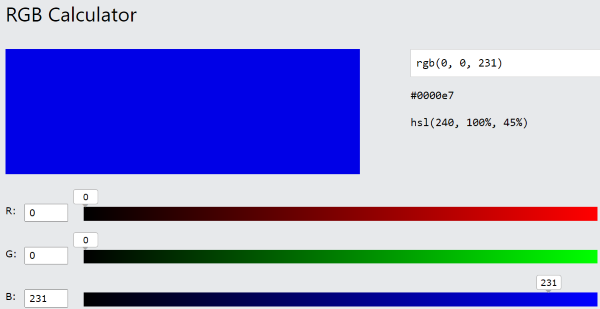

In [14]:
showarray(example_images[0])

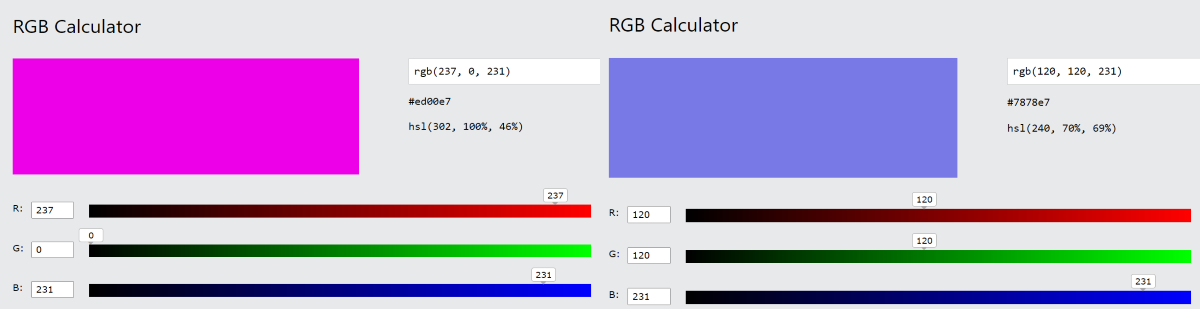

In [15]:
showarray(np.concatenate([example_images[1], example_images[2]], axis=1))

Now we can compare basic distances between our base dark blue and pink and Medium Slate Blue (name based on www.color-name.com)
|             |             pink                            |            second                            |
|:------------|:-------------------------------------------:|---------------------------------------------:|
|chebyshew    |  max(|237-0|,|0-0|,|231-231|) = 237         |  max(|120-0|,|120-0|,|231-231|) = 120        |
|manhattan    |     (|237-0|+|0-0|+|231-231|) = 237         |     (|120-0|+|120-0|+|231-231|) = 240        |
|euclidian    | sqrt(|237-0|^2+|0-0|^2+|231-231|^2) = 237   | sqrt(|120-0|^2+|120-0|^2+|231-231|^2) = 170  |

The best result is given by chebyshew (pink has big distance and Medium Slate Blue which is still blue has smaller difference)

## Function get image
This function generate image based on two paramaters h and v where h maens how far horizontally is the pixel with which we are comparing and v how far vertically. "Images_original" are images on which we based. 
We compare allways one pixel. In the experience it turned out that the results are much worse when based on a group of pixels. Better results are obtained when we create several images and then assemble them into one. This approach is also less complex computationally. 

In [16]:
def get_image(images_original, h, v):
    images = []
    for i in images_original:
        images.append(np.copy(i))
    for i in range(images[0].shape[0] - v):
        for j in range(images[0].shape[1] - h):
            pixels = [image[i+v][j+h] for image in images]
            pixel = get_pixel(pixels,images[0][i][j])
            for image in images:
                image[i + v][j + h] = pixel
    return images[0]

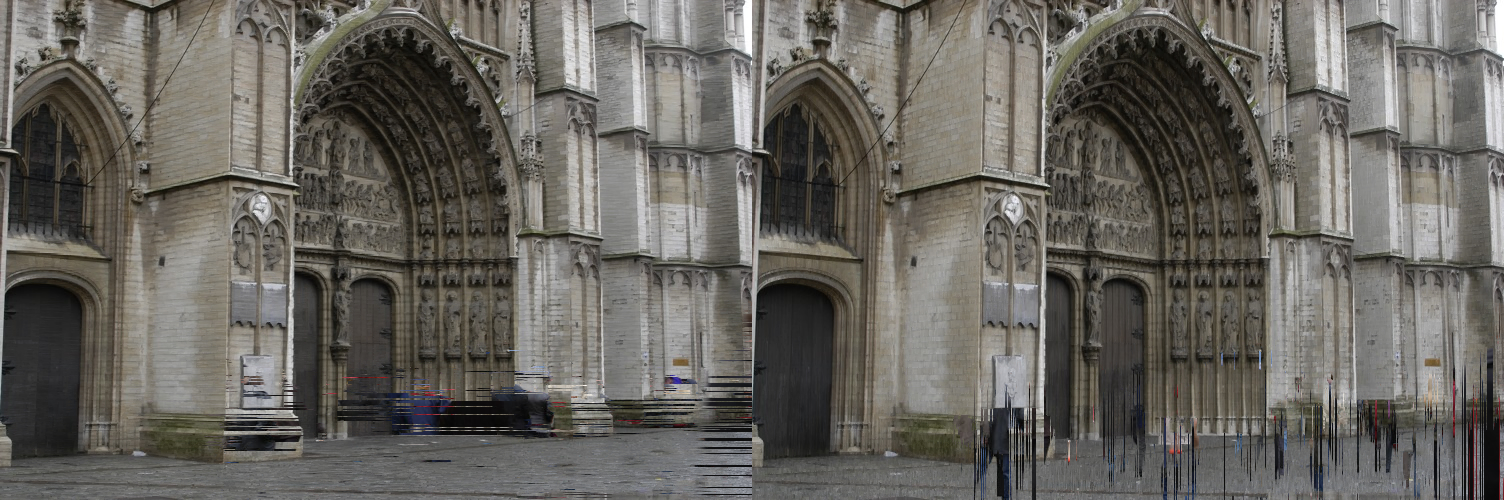

In [24]:
showarray(np.concatenate([get_image(images, 1, 0),get_image(images, 0, 1)], axis=1))

## Function get final images
We specify how much image in each direction we want.

In [17]:
def get_final_images(images, i, v = False):
    final_images = []
    for i in range(1, i + 1):
        final_images.append(get_image(images,i,0))
        final_images.append(get_image(images,0,i))
        if(v):
            final_images.append(get_image(images,i,i))
    return final_images

In [18]:
final_images = get_final_images(images, 10)

In [22]:
my_median = (np.median(np.array(final_images), axis=0).astype(np.uint8))
my_average = (np.average(np.array(final_images), axis=0).astype(np.uint8))

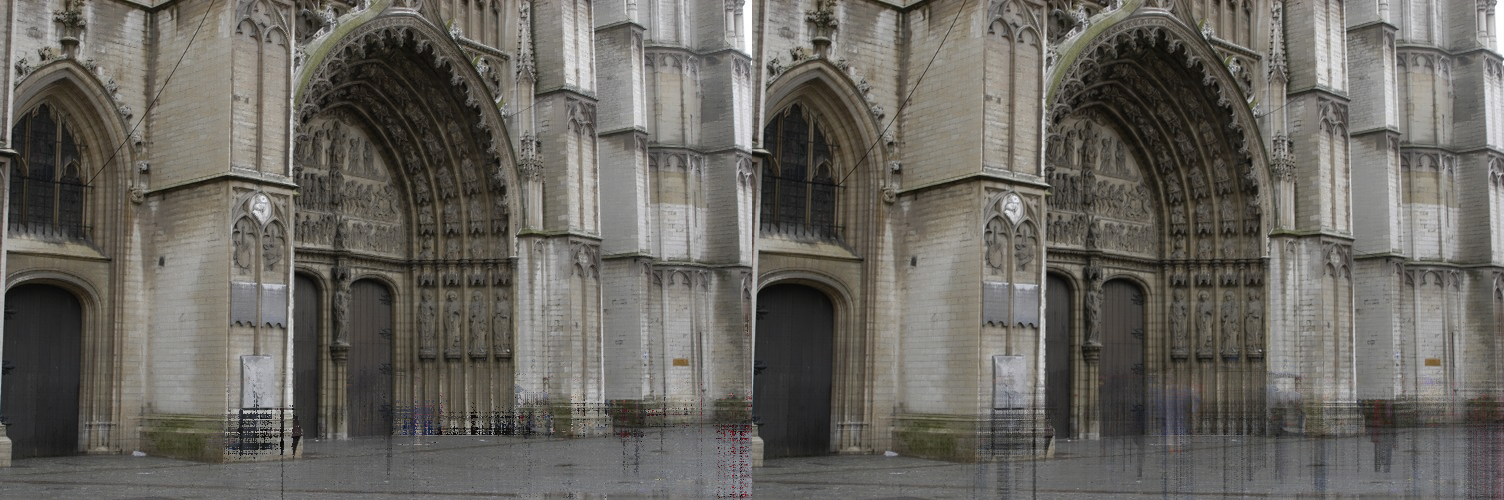

In [23]:
showarray(np.concatenate([my_median,my_average], axis=1))